<a href="https://colab.research.google.com/github/htapiagroup/sistdist/blob/master/MCA_SDU_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas Distribuidos y Ubicuos II
## MCA Tercer cuatrimestre
### Horacio Tapia-McClung

## Resumen Semana 5

* arreglos multidimensionales con `numpy` y `dask`
* DataFrames con `pandas` y `dask`

* leyendo multiples archivos de texto (.csv)
* construyendo flujos retrasados
* cronometraje de operaciones con dataframes, `pandas` vs. `dask`

Cuando usar `pandas` y cuando usar `dask`?

# Analizando los viajes en taxi de la Ciudad de NY

In [0]:
# download taxi data

import os
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL = 'wget https://s3.amazonaws.com/nyc-tlc/trip+data/'+plantilla
urls = (plantillaURL.format(k) for k in range(1,13)) # generator
for url in urls:
  os.system(url)

In [6]:
ls

sample_data/                 yellow_tripdata_2018-07.csv
yellow_tripdata_2018-01.csv  yellow_tripdata_2018-08.csv
yellow_tripdata_2018-02.csv  yellow_tripdata_2018-09.csv
yellow_tripdata_2018-03.csv  yellow_tripdata_2018-10.csv
yellow_tripdata_2018-04.csv  yellow_tripdata_2018-11.csv
yellow_tripdata_2018-05.csv  yellow_tripdata_2018-12.csv
yellow_tripdata_2018-06.csv


In [7]:
%ll -h yellow_tripdata_2018-*.csv

-rw-r--r-- 1 root 737M Aug  3  2018 yellow_tripdata_2018-01.csv
-rw-r--r-- 1 root 715M Aug  3  2018 yellow_tripdata_2018-02.csv
-rw-r--r-- 1 root 794M Aug  3  2018 yellow_tripdata_2018-03.csv
-rw-r--r-- 1 root 784M Aug  3  2018 yellow_tripdata_2018-04.csv
-rw-r--r-- 1 root 777M Aug  3  2018 yellow_tripdata_2018-05.csv
-rw-r--r-- 1 root 734M Aug  3  2018 yellow_tripdata_2018-06.csv
-rw-r--r-- 1 root 661M Feb  5 15:07 yellow_tripdata_2018-07.csv
-rw-r--r-- 1 root 661M Feb  5 15:09 yellow_tripdata_2018-08.csv
-rw-r--r-- 1 root 678M Feb  5 15:12 yellow_tripdata_2018-09.csv
-rw-r--r-- 1 root 744M Feb  5 15:14 yellow_tripdata_2018-10.csv
-rw-r--r-- 1 root 687M Feb  5 15:16 yellow_tripdata_2018-11.csv
-rw-r--r-- 1 root 689M Feb  5 15:19 yellow_tripdata_2018-12.csv


In [0]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv('yellow_tripdata_2018-01.csv')
df.shape

(8759874, 17)

In [10]:

df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')

In [11]:
df['payment_type'].value_counts()

1    6105871
2    2598947
3      43204
4      11852
Name: payment_type, dtype: int64

Using `dask`

# Using `dask`

## Reading & cleaning files

Here you'll be working with a subset of the NYC Taxi Trip data. The first step is to use the Dask dd.read_csv() function to read multiple files at once. Dask will automatically concatenate the contents of the files into a single DataFrame. Notice that you'll use the option assume_missing=True in the call to dd.read_csv() to suppress warning messages.

Your job is to use a glob pattern containing the * character to read all of the CSV files from the taxi/ subdirectory into a single Dask DataFrame. You'll then construct a new column called 'tip_fraction' using the 'tip_amount' and 'total_amount' columns. The 'total_amount' is the sum of the fare, other fees, and the tip_amount.

## Instrucciones


 * Read all .csv files from the taxi/ directory (with a wildcard pattern *).
 * Create a column 'tip_fraction', which is the result of the 'tip_amount' divided by the difference of the 'total_amount' and 'tip_amount' columns.
 * Convert the 'tpep_dropoff_datetime' column to datetime using dd.to_datetime().
 * Create a column 'hour' using the .dt.hour attribute of the 'tpep_dropoff_datetime' column.


In [0]:
import dask.dataframe as dd
# Read all .csv files: df
df = dd.read_csv('taxi/yellow*.csv', assume_missing=True)

# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

## Filtering & grouping data

You have the Dask dataframe df prepared using multiple CSV files from the last exercise. It contains a subset of the 2015 yellow taxi ride data from New York City with some additional columns from preprocessing. Remember, none of the files have actually been loaded, nor has any computation been done to construct the new columns.

Your task now is to build a pipeline of computations to compute the hourly average tip fraction for each hour of the day across the entire year of data. You'll have to filter for payments of type 1 (credit card transactions) from the 'payment_type' column, group transactions using the 'hour' column, and finally aggregate the mean from the 'tip_fraction' column.

## Instrucciones

* Filter out rows where payment_type is 1 and call the resulting dataframe credit.
* Group credit using the 'hour' column and call the result 'hourly'.
* Select the 'tip_fraction' column and aggregate the mean.
* Display the data type of result.


In [0]:
# Filter rows where payment_type == 1: credit
credit = df[df.payment_type==1]

# Group by 'hour' column: hourly
hourly = credit.groupby('hour')

# Aggregate mean 'tip_fraction' and print its data type
result = hourly['tip_fraction'].mean()
print(type(result))

## Computing & plotting

Now that you've got the entire delayed pipeline prepared it's time compute and plot the result. Matplotlib has been imported for you as plt.

Warning: The execution of of this exercise is expected to be several seconds.

## Instrucciones


* Perform the computation on result and assign it to tip_frac.
* Print the type of tip_frac.
* Hit 'Submit Answer to view the plot.


In [0]:
import matplotlib.pyplot as plt
# Perform the computation
tip_frac = result.compute()

# Print the type of tip_frac
print(type(tip_frac))

# Generate a line plot using .plot.line()
tip_frac.plot.line()
plt.ylabel('Tip fraction')
plt.show()

# Exploratory data analysis using `pandas`

homework will be using `dask`

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [13]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


Usando el archivo que se encuentra [en este enlace](https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv) podemos asocir datos de localizacion a las zonas de **P**ick**U**p y **D**rop**O**ff (columndas 8 y 9)

In [20]:
df.columns[7:9]


Index(['PULocationID', 'DOLocationID'], dtype='object')

In [21]:
!wget https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv

--2019-06-10 16:16:00--  https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.138.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.138.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12322 (12K) [application/octet-stream]
Saving to: ‘taxi+_zone_lookup.csv’

taxi+_zone_lookup.c 100%[===================>]  12.03K  --.-KB/s    in 0s      

2019-06-10 16:16:00 (159 MB/s) - ‘taxi+_zone_lookup.csv’ saved [12322/12322]



Un archivo `shape`  con informacion geografica de las zonas puede descargarse [de aqui](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip)

In [23]:
!wget https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip

--2019-06-10 16:18:39--  https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.145.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.145.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1025147 (1001K) [application/zip]
Saving to: ‘taxi_zones.zip’

taxi_zones.zip      100%[===================>]   1001K  --.-KB/s    in 0.07s   

2019-06-10 16:18:39 (14.1 MB/s) - ‘taxi_zones.zip’ saved [1025147/1025147]



In [29]:
!unzip taxi_zones.zip

Archive:  taxi_zones.zip
  inflating: taxi_zones.prj          
  inflating: taxi_zones.dbf          
  inflating: taxi_zones.shp          
  inflating: taxi_zones.shp.xml      
  inflating: taxi_zones.shx          
  inflating: taxi_zones.sbn          
  inflating: taxi_zones.sbx          


In [24]:
!pip install pyshp

     |████████████████████████████████| 225kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
import shapefile
from shapely.geometry import Polygon

In [75]:
!pip install descartes

In [0]:
from descartes.patch import PolygonPatch

In [0]:
sf = shapefile.Reader("taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]


In [0]:
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

Necesitamos una forma de asociar el contenido de las columnas en el diccionario `shape` con el `dataframe`, una forma es como sigue: 

* Cada zona esta contenida en un `record` guardado en el objeto `sf`, un ejemplo esta en el objeto  
 > `sf.shapeRecord()`
* Cada uno de estos registros es un `shape` con diversos atributos, entre ellos `bbox`
  > `sf.shapeRecord().shape.bbox`
* podemos tomar el punto medio de cada rectangulo correspondiente a las zonas y de ahi asociar las coordenadas de dicha zona a la ID de localizacion de la base de datos
* Identificamos la columna donde estan las IDs en el diccionario `shp_dic`
  > `shp_dic['LocationID']`
* Iteramos sobre todos los registros en `.shapeRecords()`

In [50]:
sf.shapeRecord().shape.bbox

[931553.4909607167, 183788.04973023868, 941810.0086498931, 197256.2108251324]

In [34]:
shp_dic['LocationID']

4

In [0]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


Las latitudes y longitudes se especifican en coordenadas Mercator Web, necesitamos hacer algo con ellas!

In [63]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,zone,longitude,latitude
0,1,1,0.000782,0.116357,EWR,Newark Airport,9.366817e+05,190522.130278
1,2,2,0.004866,0.433470,Queens,Jamaica Bay,1.033536e+06,161853.982300
2,3,3,0.000314,0.084341,Bronx,Allerton/Pelham Gardens,1.027136e+06,254730.010849
3,4,4,0.000112,0.043567,Manhattan,Alphabet City,9.904240e+05,203100.040432
4,5,5,0.000498,0.092146,Staten Island,Arden Heights,9.321332e+05,139954.541936


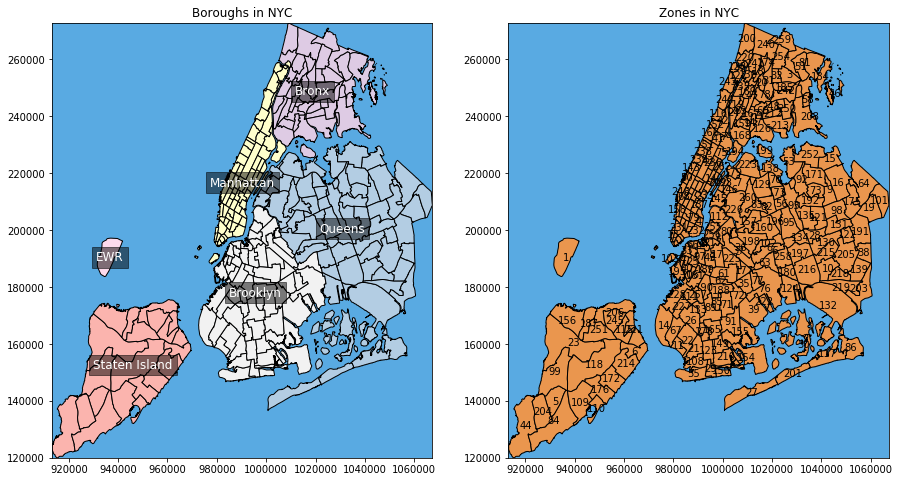

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

## Veamos los puntos de la `dataframe`

In [0]:
df_loc['LocationID'].tolist()

# Funciones auxiliares

In [0]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max


In [0]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


In [0]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
